In [12]:
import os 
import PIL
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader 
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.utils.data.sampler as sampler
from torch import nn, optim
import torch.nn.functional as F




In [13]:
# Load the data
training_file = 'data/train.p'
validation_file = 'data/valid.p'
testing_file = 'data/test.p'

with open(training_file, mode = "rb") as f:
    train = pickle.load(f) # 파일을 로드함 
with open(validation_file, mode = "rb") as f:
    valid = pickle.load(f)
with open(testing_file, mode = "rb") as f:
    test = pickle.load(f) 
X_train, y_train = train['features'], train['labels'] 
X_valid, y_valid =  valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']



In [14]:
# Number of training examples
n_train = len(X_train)
# Number of validation examples.
n_valid = len(X_valid)
# Number of testing examples.
n_test = len(X_test)

# The shape of an traffic sign image
image_shape = X_train[0].shape[:-1]

# Number of unique classes/labels in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


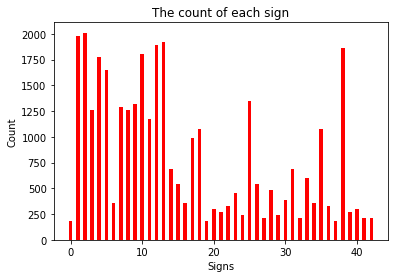

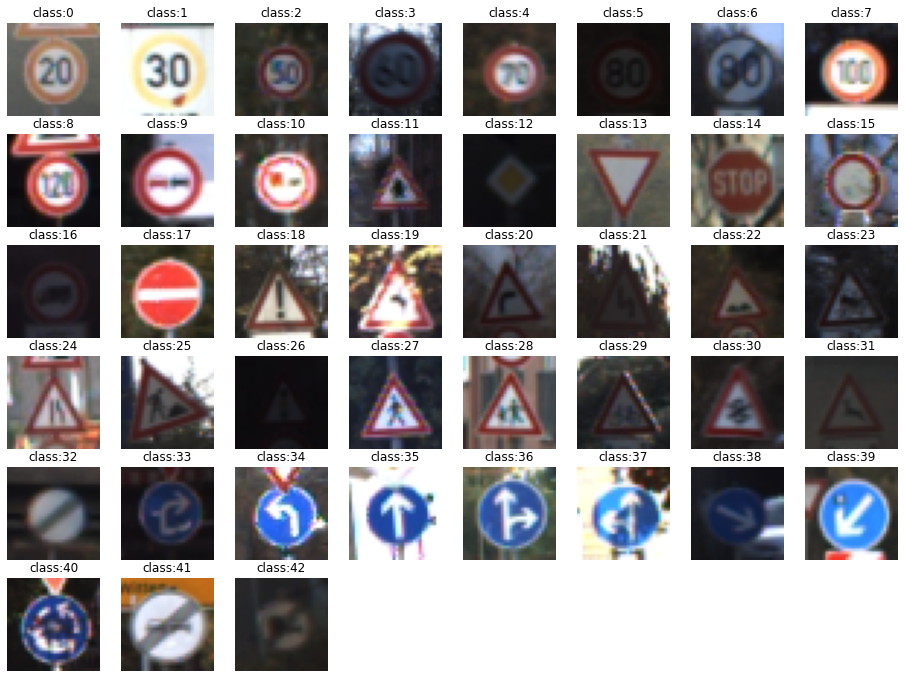

In [15]:
# Data exploration visualization 
flg, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(y_train), 0.5, color = 'r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

plt.figure(figsize = (16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class:{}'.format(c))
    plt.imshow(X_train[i])

In [17]:
# Design and Test a Baseline Mode

#Custom DataSet & DataLoader 
class PickledDataset(Dataset):
    def __init__(self, file_path, transform = None):
        with open(file_path, mode = 'rb') as f:
            data = pickle.load(f)
            self.features = data['features']
            self.labels = data['labels']
            self.count = len(self.labels)
            self.transform = transform
    def __getitem__(self, index):
        feature = self.features[index]
        if self.transform is not None:
            feature = self.transform(feature)
        return (feature, self.labels[index])
    
    def __len__(self):
        return self.count
    
class WrappendDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func
    
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))
    
    

In [26]:
#BaseLine Model 
class BaselineNet(nn.Module):
    def __init__(self, gray = False):
        super(BaselineNet, self).__init__()
        input_chan = 1 if gray else 3
        self.conv1 = nn.Conv2d(input_chan, 6, 5) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 43)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    

In [18]:
# Training

torch.manual_seed(1)

In [19]:
train_dataset = PickledDataset(training_file, transform = transforms.ToTensor())
valid_dataset = PickledDataset(validation_file, transform = transforms.ToTensor())
test_dataset = PickledDataset(testing_file, transform = transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = 64, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def to_device(x, y):
    return x.to(device), y.to(device, dtype = torch.int64)

train_loader = WrappendDataLoader(train_loader, to_device)
valid_loader = WrappendDataLoader(valid_loader, to_device)
test_loader = WrappendDataLoader(test_loader, to_device)

In [27]:
model = BaselineNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
n_epochs = 20

In [28]:
def loss_batch(model, loss_func, x, y, opt = None):
    loss = loss_func(model(x), y)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item(), len(x)

    

In [29]:
def valid_batch(model, loss_func, x, y):
    output = model(x)
    loss = loss_func(output, y)
    pred = torch.argmax(output, dim = 1)
    correct = pred == y.view(*pred.shape)
    return loss.item(), torch.sum(correct).item(), len(x)



In [30]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        
        #Train model
        model.train()
        losses, nums = zip(*[loss_batch(model, loss_func, x, y, opt) for x, y in train_dl])
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        
        #Validation model
        model.eval()
        with torch.no_grad():
            losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in valid_dl])
            valid_loss = np.sum(np.multiply(losses, nums) / np.sum(nums))
            valid_accuracy = np.sum(corrects) / np.sum(nums)*100
            print(f"[Epoch {epoch+1}/{epochs}] "
                  f"Train loss: {train_loss:.6f}\t"
                  f"Validation loss: {valid_loss:.6f}\t",
                  f"Validation accruacy: {valid_accuracy:.3f}%")            
        

In [31]:
def evaluate(model, loss_func, dl):
    model.eval()
    with torch.no_grad():
        losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in dl])
        test_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        test_accuracy = np.sum(corrects) / np.sum(nums) * 100
        
    print(f"Test loss: {test_loss:.6f}\t"
          f"Test accruacy: {test_accuracy:.3f}%")

In [32]:
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)


[Epoch 1/20] Train loss: 3.676090	Validation loss: 3.598352	 Validation accruacy: 5.238%
[Epoch 2/20] Train loss: 3.485061	Validation loss: 3.575792	 Validation accruacy: 5.442%
[Epoch 3/20] Train loss: 3.455669	Validation loss: 3.526733	 Validation accruacy: 7.234%
[Epoch 4/20] Train loss: 3.334454	Validation loss: 3.299106	 Validation accruacy: 18.957%
[Epoch 5/20] Train loss: 2.678223	Validation loss: 2.304752	 Validation accruacy: 39.093%
[Epoch 6/20] Train loss: 1.693715	Validation loss: 1.572381	 Validation accruacy: 56.236%
[Epoch 7/20] Train loss: 1.126744	Validation loss: 1.211498	 Validation accruacy: 64.943%
[Epoch 8/20] Train loss: 0.829999	Validation loss: 0.931510	 Validation accruacy: 73.288%
[Epoch 9/20] Train loss: 0.653638	Validation loss: 0.889867	 Validation accruacy: 74.739%
[Epoch 10/20] Train loss: 0.548010	Validation loss: 0.750772	 Validation accruacy: 79.410%
[Epoch 11/20] Train loss: 0.461022	Validation loss: 0.737825	 Validation accruacy: 80.431%
[Epoch 12/2